In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import preprocessing_d
importlib.reload(preprocessing_d)
import preprocessing_d
import seaborn as sns


In [393]:
bikes=pd.read_csv("bikes.csv")
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500


In [394]:
bikes.shape

(7857, 8)

In [395]:
bikes1=preprocessing_d.BikePreprocess(bikes)
#bikes1.preprocess_dataset()
bikes1=bikes1.preprocess_dataset()

In [396]:
bikes1[bikes1["price"]==0]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc


In [397]:
bikes1=preprocessing_d.BikePreprocess(bikes)

In [398]:
bikes=bikes1.preprocess_dataset()

In [399]:
df = bikes[(bikes['price'] < 500000) & (bikes['kms_driven'] < 200000)]
df.shape

lower_cap = bikes['price'].quantile(0.01)
upper_cap = bikes['price'].quantile(0.99)
df['price'] = bikes['price'].clip(lower=lower_cap, upper=upper_cap)
df["price"]
bikes=bikes.loc[df["price"].index]

In [400]:
location_encoder_freq=bikes['location'].value_counts()
model_name_encoder_freq=bikes['model_name'].value_counts()
brand_encoder_freq=bikes['brand'].value_counts()

In [401]:
categorical_cols = ['model_name', 'location', 'brand']
numerical_cols_x= ["kms_driven", "mileage", "power", "cc"]
y_col = "price"
categorical_encoders_freq={'model_name':model_name_encoder_freq, 'location':location_encoder_freq, 'brand':brand_encoder_freq}

In [402]:
import pickle
pickle.dump(categorical_encoders_freq, open("categorical_encoders_freq.pkl", "wb"))

In [403]:
from preprocessing_d import ML_scale_tranfsormed
bikes_trans=ML_scale_tranfsormed(bikes).transform_data_freq()

In [404]:
from sklearn.ensemble import IsolationForest


X = bikes_trans[numerical_cols_x]

# Initialize model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
bikes_trans['anomaly'] = iso_forest.fit_predict(X)

# -1 = anomaly, 1 = normal
df_outliers = bikes_trans[bikes_trans['anomaly'] == -1]
df_cleaned = bikes_trans[bikes_trans['anomaly'] == 1]
df_cleaned.drop("anomaly", axis=1, inplace=True)
bikes_trans=df_cleaned

In [405]:
bikes_trans.shape

(7254, 10)

In [406]:
bikes_trans.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25,2017,17000.0,1,331,35.0,19.0,63500,2091,220.0
1,69,2016,50000.0,1,331,35.0,19.0,115000,1744,350.0
2,6,2012,14795.0,1,331,30.0,28.0,300000,52,250.0
3,31,2017,28.0,1,6,28.0,34.0,100000,2091,400.0
4,8,2020,2000.0,1,757,30.0,30.0,197500,46,330.0


In [ ]:
import hdbscan

cluster=hdbscan.HDBSCAN(min_cluster_size=6, min_samples=15, metric='euclidean', cluster_selection_method='eom')

In [408]:
# Scaling Columns and Data Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler_cluster = StandardScaler()
scaler_cluster.fit_transform(bikes_trans)


array([[ 0.57789981,  0.39928125,  0.1092848 , ..., -0.39572963,
         1.15277719, -0.05478997],
       [ 3.21680779,  0.14465389,  2.12426822, ...,  0.5437713 ,
         0.66491117,  1.13418372],
       [-0.56162863, -0.87385553, -0.02535273, ...,  3.91867755,
        -1.71396292,  0.21958858],
       ...,
       [ 0.21804873,  0.14465389, -0.53752488, ..., -0.42783684,
         1.15277719, -0.42062802],
       [ 2.19722971,  0.14465389, -0.46932075, ..., -0.6602493 ,
         1.15277719, -0.69500657],
       [ 0.51792463,  0.14465389, -0.01283541, ..., -0.36836552,
         1.15277719, -0.05478997]], shape=(7254, 10))

In [409]:
bikes_HDBSCAN=pd.DataFrame(scaler_cluster.fit_transform(bikes_trans), columns=bikes_trans.columns, index=bikes_trans.index)

In [410]:
cluster.fit_predict(bikes_HDBSCAN)

array([18, 13, -1, ..., 18, -1, 18], shape=(7254,))

In [411]:
bikes_HDBSCAN["Cluster"]=cluster.fit_predict(bikes_HDBSCAN)

In [412]:
final_cluster=bikes_HDBSCAN[bikes_HDBSCAN["Cluster"]!=-1][bikes_trans.columns]

In [413]:
final_cluster.shape

(6269, 10)

In [414]:

final_cluster=pd.DataFrame(scaler_cluster.inverse_transform(final_cluster), columns=final_cluster.columns, index=final_cluster.index)

In [415]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
X=final_cluster.drop("price", axis=1)
y=final_cluster["price"]
# log transformation
y=np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [416]:
"""from sklearn.preprocessing import QuantileTransformer
qt_normal_x = QuantileTransformer(output_distribution='normal', random_state=42)

X_train[numerical_cols_x] = qt_normal_x.fit_transform(X_train[numerical_cols_x])
X_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])"""

"from sklearn.preprocessing import QuantileTransformer\nqt_normal_x = QuantileTransformer(output_distribution='normal', random_state=42)\n\nX_train[numerical_cols_x] = qt_normal_x.fit_transform(X_train[numerical_cols_x])\nX_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])"

In [417]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the base model
cat_model = CatBoostRegressor(random_seed=42, verbose=False)

# Define the hyperparameter grid
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='r2',        # or use 'neg_root_mean_squared_error'
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
model=grid_search.best_estimator_

# ===== 6. Evaluate =====
y_pred = model.predict(X_test)
# Suppose you already calculated RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# Check price statistics in bikes1
mean_price = y_train.mean()
median_price = pd.DataFrame(y_train).median()
min_price = y_train.min()
max_price = y_train.max()

# Calculate relative error (as a percentage of mean price)
relative_error = (rmse / mean_price) * 100
print("R2 Score:", r2_score(y_test, y_pred))
# Print comparison
print(f"📌 RMSE: {rmse:}")
print(f"💰 Mean Price: {mean_price}")
print(f"📈 Median Price: {median_price}")
print(f"⬇️ Min Price: {min_price}")
print(f"⬆️ Max Price: {max_price}")
print(f"📊 RMSE as % of mean price: {relative_error:.2f}%")

# Optional quick judgement
if relative_error < 10:
    print("✅ Excellent RMSE (less than 10% of mean price)")
elif relative_error < 20:
    print("✅ Good RMSE (10–20% of mean price)")
elif relative_error < 30:
    print("⚠️ Acceptable RMSE (20–30% of mean price)")
else:
    print("❌ High RMSE (more than 30% of mean price) — could be improved")
print("Adjusted R-squared:", 1 - (1 - model.score(X_test, y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

Best Parameters: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}
R2 Score: 0.9299555195721716
📌 RMSE: 0.18155723021881529
💰 Mean Price: 11.156376516930266
📈 Median Price: price    11.225257
dtype: float64
⬇️ Min Price: 7.601402334583733
⬆️ Max Price: 12.758701222519067
📊 RMSE as % of mean price: 1.63%
✅ Excellent RMSE (less than 10% of mean price)
Adjusted R-squared: 0.9294487669002661


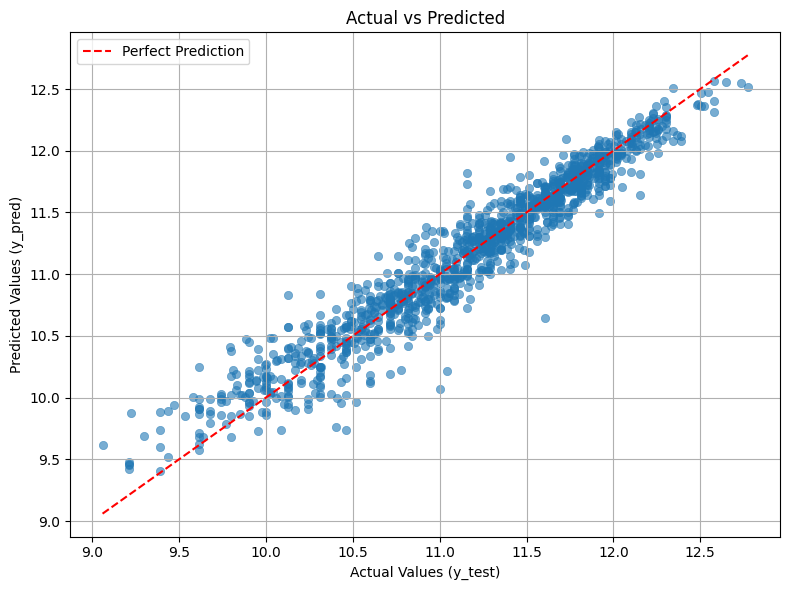

In [418]:
y_test = y_test
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [419]:
# function for preprocessing
from preprocessing_d import ML_scale_tranfsormed

def ml_preprocess(bikes):
    bikes1=preprocessing_d.BikePreprocess(bikes)
    bikes1=bikes1.preprocess_dataset()
    bikes_trans=ML_scale_tranfsormed(bikes1).transform_data_freq()
    return bikes_trans

In [420]:
bi=pd.read_csv("bikes.csv")
ml_preprocess(bi)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25.0,2017,17000.0,1,331.0,35.0,19.0,63500,2091.0,220.0
1,69.0,2016,50000.0,1,331.0,35.0,19.0,115000,1744.0,350.0
2,6.0,2012,14795.0,1,331.0,30.0,28.0,300000,52.0,250.0
3,31.0,2017,28.0,1,6.0,28.0,34.0,100000,2091.0,400.0
4,8.0,2020,2000.0,1,757.0,30.0,30.0,197500,46.0,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,9.0,2011,7000.0,1,24.0,42.0,16.0,55000,744.0,150.0
7853,2.0,2015,80.0,1,1401.0,80.0,7.7,28000,2091.0,100.0
7854,19.0,2016,6407.0,1,757.0,65.0,17.0,61740,2091.0,180.0
7855,52.0,2016,7524.0,1,757.0,57.0,11.0,49000,2091.0,150.0
